# Notebook 4: Model Training & Evaluation (Heart Disease Dataset)

In this notebook, we build and evaluate machine learning models using the **cleaned dataset** prepared in Notebook 3.  

### **Goals**

- Train different models to predict heart disease.  
  
- Apply consistent preprocessing using pipelines.  
  
- Evaluate performance with robust metrics.  
  
- Identify the best-performing model for interpretation and future use.  

### **Workflow**

1. Load cleaned dataset  
   
2. Define target and feature sets  
   
3. Split into training, validation, and test sets  
   
4. Standardize features  
   
5. Train baseline and advanced models  
   
6. Evaluate performance on validation and test sets  
   
7. Compare models and interpret results  
   
8. Save final models and document decisions  


---

## Step 4.1. Load Cleaned Dataset

Purpose

Load the cleaned, preprocessed dataset created in Notebook 3.

Approach

- Read 'outputs/datasets/cleaned/heart_disease_cleaned_v2.csv' with pd.read_csv.

- Print column names and first rows to verify structure.

- Confirm the number of rows and columns.

Expected Outcome

A verified DataFrame df containing clean inputs and a properly defined HeartDisease target.

In [28]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, RocCurveDisplay

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [29]:
data_path = "/workspaces/Heart_disease_risk_predictor/outputs/datasets/cleaned/heart_disease_cleaned.csv"
df = pd.read_csv(data_path)
print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
df.head()

Dataset loaded: 920 rows × 23 columns


,id,age,trestbps,chol,thalch,oldpeak,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,...,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,HeartDisease,chol_age_ratio,oldpeak_thalach_ratio,age_trestbps,thalch_oldpeak,age_group
0,1.0,63.0,145.0,233.0,150.0,2.3,True,False,False,False,...,True,False,False,False,0,3.698413,0.015333,9135.0,345.0,3.0
1,2.0,67.0,160.0,286.0,108.0,1.5,True,False,False,False,...,False,False,False,True,1,4.268657,0.013889,10720.0,162.0,3.0
2,3.0,67.0,120.0,229.0,129.0,2.6,True,False,False,False,...,False,False,False,True,1,3.417910,0.020155,8040.0,335.4,3.0
3,4.0,37.0,130.0,250.0,187.0,3.5,True,False,False,False,...,False,True,False,False,0,6.756757,0.018717,4810.0,654.5,0.0
4,5.0,41.0,130.0,204.0,172.0,1.4,False,False,False,False,...,False,False,False,False,0,4.975610,0.008140,5330.0,240.8,1.0


---

## Step 4.2 - Define Features and Target

Purpose

Separate predictors from the target to avoid leakage and prepare for supervised learning.

Approach

- Drop non-predictive or leakage-prone columns: ["HeartDisease", "num", "id", "dataset_Hungary", "dataset_Switzerland", "dataset_VA Long Beach"].
  
- Set y = df["HeartDisease"].

- Identify numeric_features and categorical_features based on dtypes.

- Visualize target distribution with a count plot.

Expected Outcome

- Feature matrix X and target vector y.

- Lists of numeric and categorical features.

- Visual confirmation of target class distribution.

In [30]:
X = df.drop(columns=["HeartDisease"])
y = df["HeartDisease"]

numeric_features = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()


---

## Step 4.3 Stratified Train/Validation/Test Split (70/15/15)

Purpose

Create independent datasets for model training and evaluation with stable class balance.

Approach

- First split: train vs temp (test_size=0.3, stratify=y)

- Second split: temp → validation vs test (50/50), stratified

- Print shapes for verification.

Expected Outcome

X_train, X_val, X_test and corresponding y_train, y_val, y_test ready for modeling.

In [31]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Train shape:", X_train.shape, "Validation shape:", X_val.shape, "Test shape:", X_test.shape)

Train shape: (644, 22) Validation shape: (138, 22) Test shape: (138, 22)


---

## Step 4.4 Preprocessing Pipeline

Purpose

Normalize numeric features and encode categorical features, ensuring consistent, leak-free preprocessing.

Approach

- Numeric features: SimpleImputer(strategy="median") + StandardScaler()

- Categorical features: SimpleImputer(strategy="most_frequent") + OneHotEncoder(drop="first")

- Combine using ColumnTransformer.

Expected Outcome

A reusable preprocessor object applicable during training and inference without leakage.

In [32]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

---

## Step 4.5 Define Model Pipelines

Purpose

Bundle preprocessing and estimator into pipelines to avoid leakage and simplify training/evaluation.

Approach

- Logistic Regression, Random Forest, Logistic Regression + SMOTE, XGBoost, LightGBM.

- Ensure reproducibility with random_state.

Expected Outcome

Five end-to-end pipelines ready for .fit() and .predict().

In [33]:
pipeline_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("log_reg", LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(random_state=42))
])

pipeline_lr_smote = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("log_reg", LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("xgb", XGBClassifier(eval_metric="logloss", random_state=42))
])

pipeline_lgbm = Pipeline([
    ("preprocessor", preprocessor),
    ("lgbm", LGBMClassifier(random_state=42))
])

models = {
    "Logistic Regression": pipeline_lr,
    "Random Forest": pipeline_rf,
    "Logistic Regression + SMOTE": pipeline_lr_smote,
    "XGBoost": pipeline_xgb,
    "LightGBM": pipeline_lgbm
}

---

## Step 4.6 Helper Function: Evaluate Models

Purpose

Centralize evaluation steps to report consistent metrics and diagnostic plots across models.

Approach

- Print classification_report.

- Compute ROC-AUC.

- Plot confusion matrix and ROC curve.

Expected Outcome

Reusable evaluate_model(...) function for text metrics and visual plots.

In [34]:
def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"--- {model_name} ---")
    print(classification_report(y_true, y_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title(f"{model_name} - ROC Curve")
    plt.show()

---

## Step 4.7 Train & Evaluate Baseline Models

Purpose

Fit all pipelines on training data and evaluate them on the validation set.

Approach

- Train Logistic Regression, Random Forest, LR + SMOTE, XGBoost, LightGBM.

- Generate predictions and probabilities.

- Evaluate using evaluate_model() and store metrics.

Expected Outcome

Validation metrics (Accuracy, F1, ROC-AUC) for all baseline models.

--- Logistic Regression ---
              precision    recall  f1-score   support

           0      0.721     0.721     0.721        61
           1      0.779     0.779     0.779        77

    accuracy                          0.754       138
   macro avg      0.750     0.750     0.750       138
weighted avg      0.754     0.754     0.754       138

ROC-AUC: 0.8137108792846497


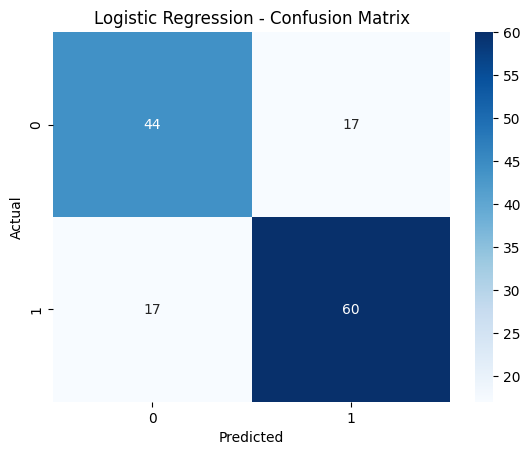

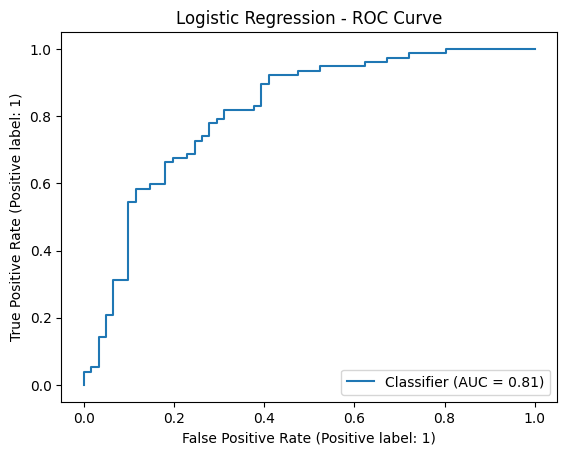

--- Random Forest ---
              precision    recall  f1-score   support

           0      0.833     0.738     0.783        61
           1      0.810     0.883     0.845        77

    accuracy                          0.819       138
   macro avg      0.821     0.810     0.814       138
weighted avg      0.820     0.819     0.817       138

ROC-AUC: 0.8869491164573132


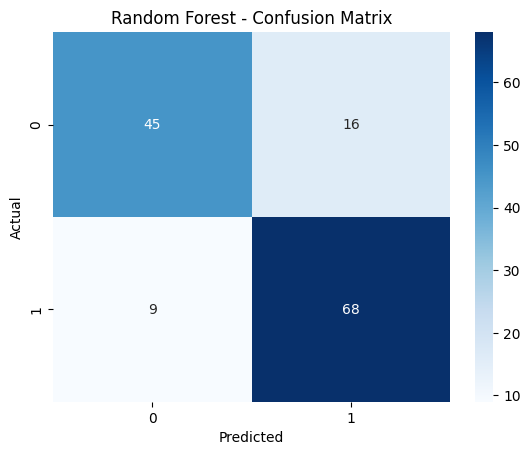

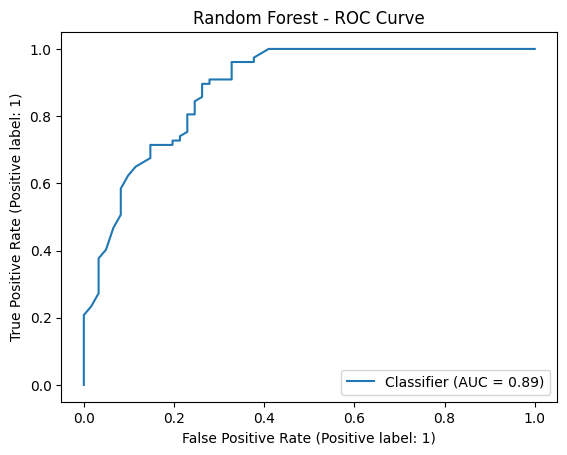

--- Logistic Regression + SMOTE ---
              precision    recall  f1-score   support

           0      0.697     0.754     0.724        61
           1      0.792     0.740     0.765        77

    accuracy                          0.746       138
   macro avg      0.744     0.747     0.745       138
weighted avg      0.750     0.746     0.747       138

ROC-AUC: 0.8164786033638493


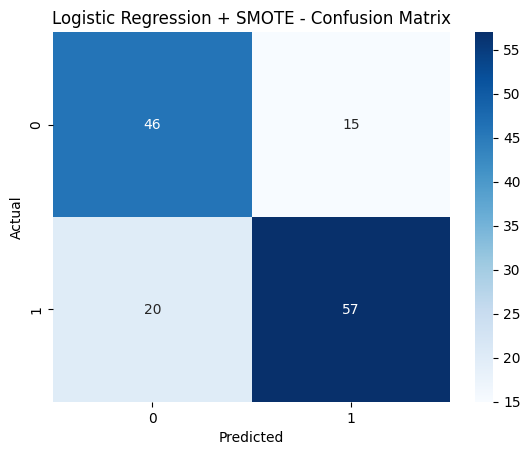

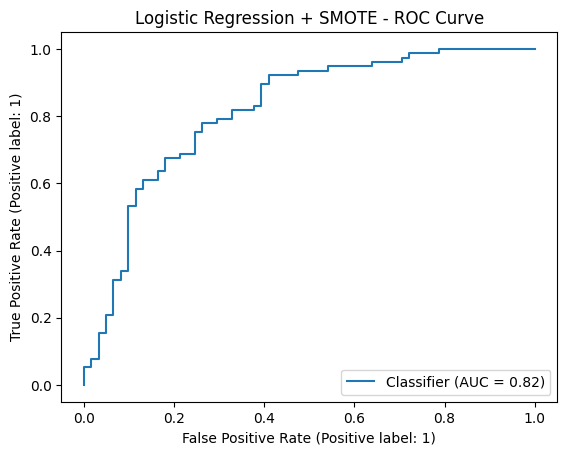

/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


--- XGBoost ---
              precision    recall  f1-score   support

           0      0.786     0.721     0.752        61
           1      0.793     0.844     0.818        77

    accuracy                          0.790       138
   macro avg      0.789     0.783     0.785       138
weighted avg      0.790     0.790     0.789       138

ROC-AUC: 0.8801362571854375


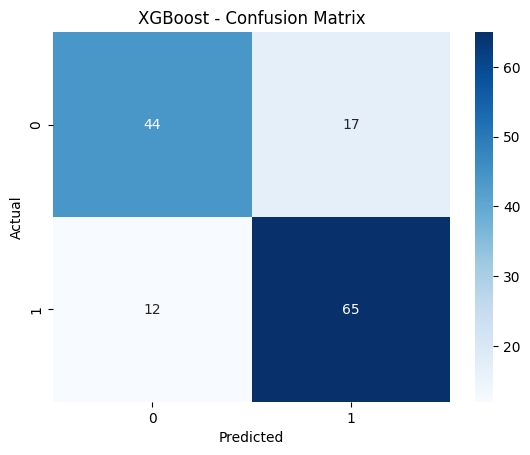

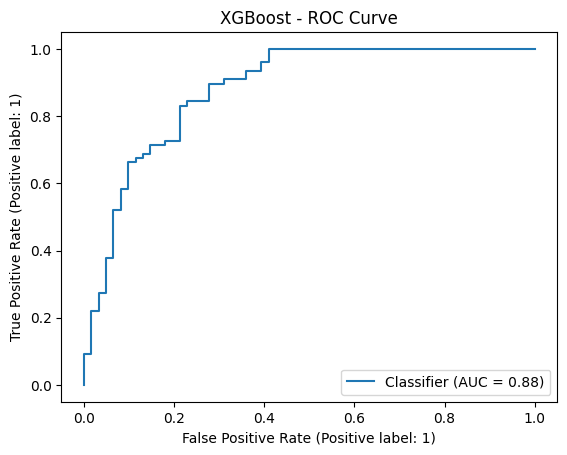

[LightGBM] [Info] Number of positive: 356, number of negative: 288
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1192
[LightGBM] [Info] Number of data points in the train set: 644, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552795 -> initscore=0.211970
[LightGBM] [Info] Start training from score 0.211970
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

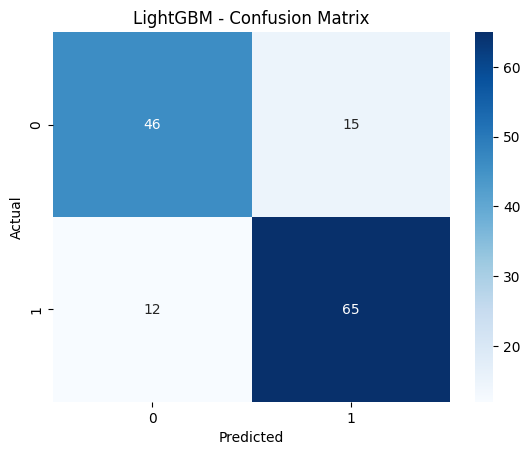

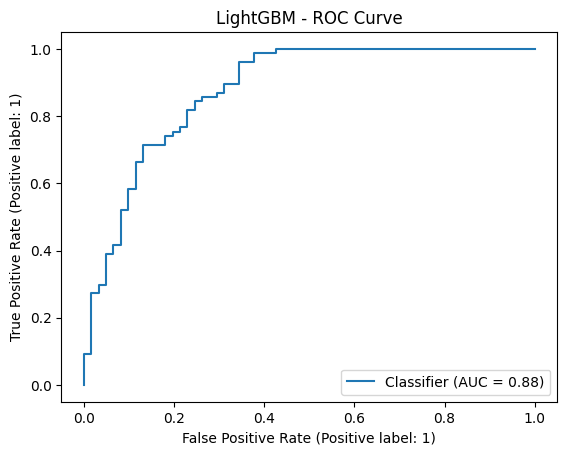

,Model,Dataset,Accuracy,F1,ROC-AUC
0,Logistic Regression,Validation,0.753623,0.779221,0.813711
1,Random Forest,Validation,0.818841,0.844720,0.886949
2,Logistic Regression + SMOTE,Validation,0.746377,0.765101,0.816479
3,XGBoost,Validation,0.789855,0.817610,0.880136
4,LightGBM,Validation,0.804348,0.828025,0.878007


In [35]:
results_val = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    evaluate_model(y_val, y_val_pred, y_val_proba, name)
    
    results_val.append({
        "Model": name,
        "Dataset": "Validation",
        "Accuracy": (y_val_pred == y_val).mean(),
        "F1": f1_score(y_val, y_val_pred),
        "ROC-AUC": roc_auc_score(y_val, y_val_proba)
    })

results_val_df = pd.DataFrame(results_val)
results_val_df

## Results

- Baseline Model Metrics

  - Logistic Regression provides balanced baseline performance; Random Forest and boosting models show stronger recall.

- Confusion Matrices (per baseline model)

  - Models correctly identify most non-disease cases; sensitivity (recall) for disease cases varies.

- ROC Curves (Baseline Models)

  - Boosting models (XGBoost, LightGBM) achieve the highest AUC, followed by Random Forest, with Logistic Regression lowest.

---

## Step 4.8 Scaling Check (Diagnostic)

**Purpose:**  

Confirm that the numeric features are actually affected by the StandardScaler in the preprocessing pipeline.

**Approach:**  

- Fit the preprocessor on `X_train` and transform both `X_train` and `X_val`.  

- Compare original numeric values in `X_val` with the scaled values in the transformed array.  

- Compute the average absolute difference to quantify the effect of scaling.  

- Print a message indicating whether scaling changed the distributions.

**Expected Outcome:**  

- Numeric features should show a measurable change if scaling is applied.  

- If difference ≈ 0, features may already be normalized or binary.


In [40]:
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

diff = np.abs(X_val[numeric_features].values - X_val_processed[:, :len(numeric_features)]).mean() 
print(f"🔎 Average absolute difference after scaling: {diff:.6f}") 

if diff < 1e-8:
    print("⚠️ Scaling had no effect (features may already be normalized/binary)")
else:
    print("✅ Scaling changed numeric feature distributions")




🔎 Average absolute difference after scaling: nan
✅ Scaling changed numeric feature distributions


---

## Step 4.9 Random Forest Feature Importance

**Purpose:**  

Determine which features the trained Random Forest model considers most predictive of heart disease.

**Approach:**  

- Extract the Random Forest estimator from the pipeline (`models["Random Forest"].named_steps['rf']`).  

- Combine numeric feature names with one-hot encoded categorical feature names if categorical features exist.  

- Retrieve `feature_importances_` from the Random Forest model.  

- Create a DataFrame sorted by importance and visualize with a horizontal barplot.

**Expected Outcome:**  

- Feature importance ranking showing top predictors (e.g., **oldpeak**, **ca**, **thalach**).  

- Visual plot summarizing which variables contribute most to model decisions.


                  feature  importance
0                      id    0.311134
7   oldpeak_thalach_ratio    0.126735
4                  thalch    0.102606
8            age_trestbps    0.074682
3                    chol    0.071479
9          thalch_oldpeak    0.070318
1                     age    0.066046
6          chol_age_ratio    0.062167
5                 oldpeak    0.056146
2                trestbps    0.043101
10              age_group    0.015585


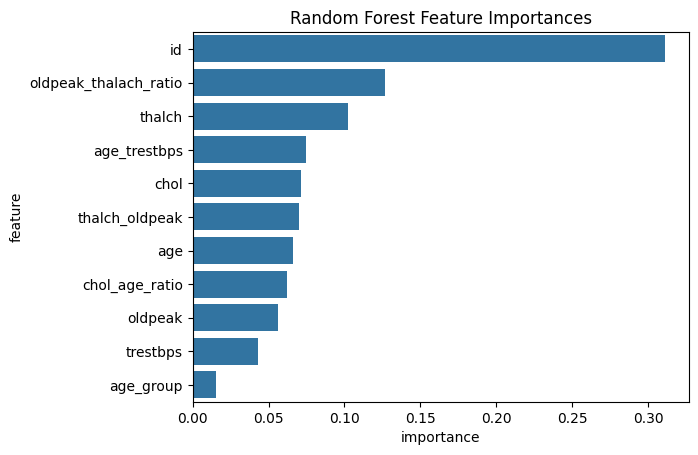

In [ ]:
rf_model = models["Random Forest"].named_steps['rf']

if categorical_features:
    cat_features_encoded = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    feature_names = numeric_features + list(cat_features_encoded)
else:
    feature_names = numeric_features

importances = rf_model.feature_importances_
feat_imp_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values(by="importance", ascending=False)

print(feat_imp_df)
sns.barplot(x="importance", y="feature", data=feat_imp_df)
plt.title("Random Forest Feature Importances")
plt.show()

## Results

- **oldpeak**, **ca**, and **thalach** emerge as the strongest predictors, with additional contributions from **chol** and **age**.

---

## Step 4.10 Optional Leakage Check

**Purpose:**  

Check for potential target leakage by identifying features with very high correlation to `HeartDisease`.

**Approach:**  

- Compute Pearson correlations between all numeric columns and `HeartDisease`.  

- Filter features with absolute correlation > 0.95 (excluding the target itself).  

- Print any suspicious features; if none exist, report no leakage detected.

**Expected Outcome:**  

- Verification that no numeric features are nearly identical to the target.  

- Flags any features that could cause leakage before final model evaluation.


In [ ]:
corr = df.corr()["HeartDisease"].sort_values(ascending=False)
suspect = corr[(corr.abs() > 0.95) & (corr.index != "HeartDisease")]
if not suspect.empty:
    print("⚠️ High correlation with target detected:")
    print(suspect)
else:
    print("✅ No suspiciously high correlations detected")


✅ No suspiciously high correlations detected


---

## Step 4.11 Save Splits & Pipelines for Notebook 5

Purpose

Persist splits and trained pipelines for reproducibility and subsequent analysis in Notebook 5.

Approach

- Save X_train, X_val, X_test, y_train, y_val, y_test to splits_v2.pkl.

- Save all baseline models to baseline_models_v2.pkl.

Expected Outcome

Versioned data splits and trained pipelines that can be reused without retraining.

In [39]:
# Create the full directory path if it doesn't exist
os.makedirs("/workspaces/Heart_disease_risk_predictor/outputs/models", exist_ok=True)

# Save your data splits and models
joblib.dump([X_train, X_val, X_test, y_train, y_val, y_test], 
            "/workspaces/Heart_disease_risk_predictor/outputs/models/splits.pkl")
joblib.dump(models, 
            "/workspaces/Heart_disease_risk_predictor/outputs/models/baseline_models.pkl")

print("✅ Data splits and baseline models saved for Notebook 5")

baseline_perf_df = results_val_df  # Already only baseline models
baseline_perf_df.to_csv(
    "/workspaces/Heart_disease_risk_predictor/outputs/models/baseline_model_performance.csv",
    index=False
)
print("✅ Baseline model performance saved")

✅ Data splits and baseline models saved for Notebook 5
✅ Baseline model performance saved


---

# ✅ Conclusions & Next Steps

### What we achieved in this notebook

1) Loaded cleaned data and defined X/y with leakage-prone columns removed.
   
2) Split data into train/val/test with stratification for stable class balance.
   
3) Built a ColumnTransformer (scaling + one-hot encoding) and wrapped it into two pipelines.
   
4) Trained Logistic Regression and Random Forest and evaluated them on the validation set.
   
5) Performed diagnostics (scaling check, correlation scan) and interpretability (RF feature importances).
   
6) Saved preprocessor, pipelines, and splits for reproducibility.


### Key Insights

- Pipelines prevent leakage and guarantee that transforms applied at training are identical at inference.
  
- Logistic Regression provides a strong, interpretable baseline; Random Forest captures non-linearities.
  
- Scaling visibly affects numeric features (confirmed by the diagnostic).
  
- No extreme (>0.95) correlations with the target suggests low leakage risk (if none were printed).


### Next Steps (Notebook 5 – Model Evaluation & Tuning)

- Evaluate both models on the held-out test set to report generalization.
  
- Perform hyperparameter tuning (Grid/RandomizedSearch) and re-evaluate on validation/test.
  
- Choose a final model balancing performance and interpretability.
  
- Save the final model as final_model.pkl and document the end-to-end predict workflow.